In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from ta.trend import MACD

DATA_DIR = '../databases/'
from utils.core import (
    load_csvs_from_folder
)


In [2]:
data_dict = load_csvs_from_folder(DATA_DIR)
for ticker in data_dict:
    df_temp = data_dict[ticker]
    df_temp['ret'] = df_temp['close'].pct_change()
    data_dict[ticker] = df_temp

tickers = list(data_dict.keys())
print(f"Loaded datasets: {list(data_dict.keys())}")



Loaded datasets: ['BTCUSD', 'DBC', 'SPX', 'XLRE']


In [78]:
def fn_compute_macd_strategy(
    df: pd.DataFrame,
    window_slow: int = 26,
    window_fast: int = 12,
    window_sign: int = 9,
 ) -> pd.DataFrame:
    """
    Compute MACD signals and strategy columns over a price DataFrame.

    Expects columns: "close" and "ret". Returns a new DataFrame with
    MACD fields, buy/sell signals, position, and strategy series.
    """
    df = df.copy()

    macd_ind = MACD(
        close=df["close"],
        window_fast=window_fast,
        window_slow=window_slow,
        window_sign=window_sign,
    )

    df["macd"] = macd_ind.macd()
    df["macd_signal"] = macd_ind.macd_signal()
    df["macd_hist"] = macd_ind.macd_diff()

    df["buy_signal"] = (
        (df["macd"] > df["macd_signal"])
        & (df["macd"].shift(1) <= df["macd_signal"].shift(1))
    )

    df["sell_signal"] = (
        (df["macd"] < df["macd_signal"])
        & (df["macd"].shift(1) >= df["macd_signal"].shift(1))
    )

    df["position"] = np.where(df["macd"] > df["macd_signal"], 1, -1)
    df["strategy"] = df["position"].shift(1) * df["ret"]

    df["buy_hold"] = df["ret"]

    return df

for ticker in data_dict.keys():
    data_dict[ticker] = fn_compute_macd_strategy(data_dict[ticker])
    
data_dict['SPX'].tail()

,close,high,low,open,volume,ret,macd,macd_signal,macd_hist,buy_signal,sell_signal,position,strategy,buy_hold
Date,,,,,,,,,,,,,,
2026-01-05,6902.049805,6920.379883,6891.560059,6892.189941,5771930000,0.006354,28.095523,28.844599,-0.749076,False,False,-1,-0.006354,0.006354
2026-01-06,6944.819824,6948.689941,6904.020020,6908.029785,5509680000,0.006197,31.797455,29.435170,2.362284,True,False,1,-0.006197,0.006197
2026-01-07,6920.930176,6965.689941,6919.189941,6945.069824,5214480000,-0.003440,32.429737,30.034084,2.395653,False,False,1,-0.003440,-0.003440
2026-01-08,6921.459961,6931.279785,6899.330078,6914.109863,5333200000,0.000077,32.597808,30.546829,2.050979,False,False,1,0.000077,0.000077
2026-01-09,6966.279785,6978.359863,6917.640137,6927.830078,5163900000,0.006475,35.933372,31.624137,4.309235,False,False,1,0.006475,0.006475


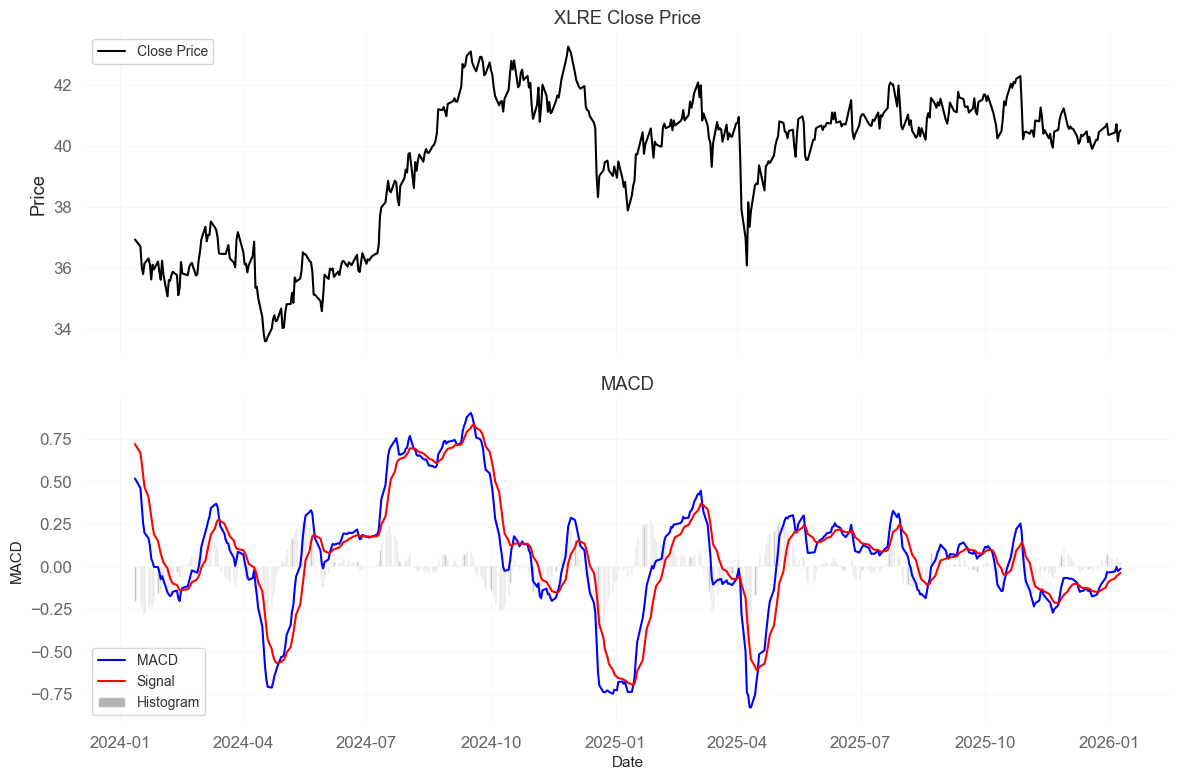

In [79]:
df = data_dict['XLRE']
ticker = 'XLRE'
df_plot = df.tail(500)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Close price
ax1.plot(df_plot.index, df_plot['close'], color='black', label='Close Price')
# Buy / Sell markers on price


ax1.legend(loc="upper left", fontsize=10)
ax1.grid(True, alpha=0.3)


ax1.set_title(f"{ticker} Close Price")
ax1.set_ylabel('Price')

# MACD lines and histogram
ax2.plot(df_plot.index, df_plot['macd'], color='blue', label='MACD')
ax2.plot(df_plot.index, df_plot['macd_signal'], color='red', label='Signal')
ax2.bar(df_plot.index, df_plot['macd_hist'], color='grey', alpha=0.6, label='Histogram')
# Buy / Sell markers on MACD

ax2.set_title('MACD')
ax2.set_ylabel('MACD')



ax2.set_ylabel("MACD", fontsize=11)
ax2.set_xlabel("Date", fontsize=11)
ax2.legend(loc="lower left", fontsize=10)
ax2.grid(True, alpha=0.3)
plt.savefig(f'../images/MACD_sample.png')
fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()

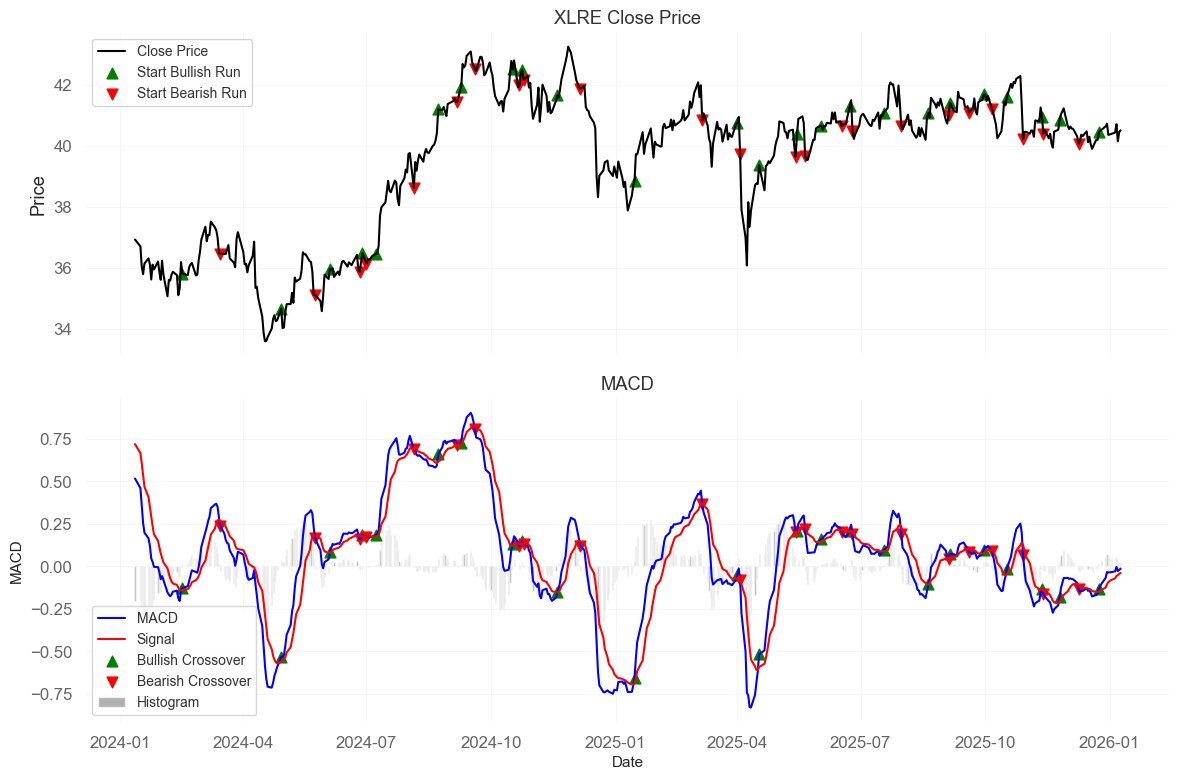

In [ ]:
df = data_dict['XLRE']
ticker = 'XLRE'
df_plot = df.tail(500)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# Close price
ax1.plot(df_plot.index, df_plot['close'], color='black', label='Close Price')
# Buy / Sell markers on price
ax1.scatter(
    df_plot.index[df_plot['buy_signal']],
    df_plot.loc[df_plot['buy_signal'], 'close'],
    marker='^', color='green', s=60, label='Start Bullish Run'
)
ax1.scatter(
    df_plot.index[df_plot['sell_signal']],
    df_plot.loc[df_plot['sell_signal'], 'close'],
    marker='v', color='red', s=60, label='Start Bearish Run'
)
ax1.legend(loc="upper left", fontsize=10)
ax1.grid(True, alpha=0.3)


ax1.set_title(f"{ticker} Close Price")
ax1.set_ylabel('Price')

# MACD lines and histogram
ax2.plot(df_plot.index, df_plot['macd'], color='blue', label='MACD')
ax2.plot(df_plot.index, df_plot['macd_signal'], color='red', label='Signal')
ax2.bar(df_plot.index, df_plot['macd_hist'], color='grey', alpha=0.6, label='Histogram')
# Buy / Sell markers on MACD
ax2.scatter(
    df_plot.index[df_plot['buy_signal']],
    df_plot.loc[df_plot['buy_signal'], 'macd'],
    marker='^', color='green', s=60, label='Bullish Crossover'
)
ax2.scatter(
    df_plot.index[df_plot['sell_signal']],
    df_plot.loc[df_plot['sell_signal'], 'macd'],
    marker='v', color='red', s=60, label='Bearish Crossover'
)
ax2.set_title('MACD')
ax2.set_ylabel('MACD')



ax2.set_ylabel("MACD", fontsize=11)
ax2.set_xlabel("Date", fontsize=11)
ax2.legend(loc="lower left", fontsize=10)
ax2.grid(True, alpha=0.3)
fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()


In [70]:
import pandas as pd
import numpy as np
import quantstats as qs

def calculate_stats(returns, periods_per_year=252):
    """Calcula estatísticas focadas para investidores intermediários usando QuantStats."""
    returns = returns.dropna()
    if len(returns) == 0:
        return {}
    
    # Usando QuantStats para calcular as métricas
    total_return = qs.stats.comp(returns) * 100  # Retorno total composto
    cagr = qs.stats.cagr(returns,) * 100  # CAGR
    volatility = qs.stats.volatility(returns, periods=periods_per_year) * 100  # Volatilidade anualizada
    sharpe = qs.stats.sharpe(returns, periods=periods_per_year)  # Sharpe Ratio
    max_dd = qs.stats.max_drawdown(returns) * 100  # Max Drawdown
    win_rate = qs.stats.win_rate(returns) * 100  # Win Rate
    profit_factor = qs.stats.profit_factor(returns)  # Profit Factor
    
    return {
        'Retorno Total': total_return,
        'CAGR': cagr,
        'Volatilidade': volatility,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor
    }

# Cria df_metrics com dados para cada ticker
rows = []
for ticker, df in data_dict.items():
    strat_stats = calculate_stats(df['strategy'])
    bh_stats = calculate_stats(df['buy_hold'])
    
    for metric in strat_stats.keys():
        rows.append({
            'Ticker': ticker,
            'Métrica': metric,
            'Estratégia': strat_stats[metric],
            'Buy & Hold': bh_stats[metric],
            'Diferença': strat_stats[metric] - bh_stats[metric]
        })

df_metrics = pd.DataFrame(rows)
df_metrics[df_metrics['Ticker']=='BTCUSD']

,Ticker,Métrica,Estratégia,Buy & Hold,Diferença
0,BTCUSD,Retorno Total,4578.589031,19744.400888,-15165.811857
1,BTCUSD,CAGR,26.417359,38.057247,-11.639888
2,BTCUSD,Volatilidade,55.809379,55.781374,0.028005
3,BTCUSD,Sharpe Ratio,0.696547,0.859476,-0.162929
4,BTCUSD,Max Drawdown,-59.956672,-83.399009,23.442337
5,BTCUSD,Win Rate,50.447617,52.625212,-2.177595
6,BTCUSD,Profit Factor,1.143125,1.179512,-0.036387


In [77]:
from IPython.display import display, HTML
import html as _html

def generate_dark_report(df_metrics):
    """Gera relatório HTML em dark mode sem injetar <style> global."""

    container_style = (
        "display:flex; flex-wrap:wrap; "
        "column-gap:28px; row-gap:28px; "   # <-- espaço entre os cards (ajuste aqui)
        "background:#1a1a1a; padding:15px;"
    )
    card_style = (
        "border:1px solid #333; padding:12px; "
        "min-width:380px; background:#252525;"
    )
    title_style = (
        "font-size:1.1em; font-weight:bold; text-align:center; "
        "color:#fff; border-bottom:1px solid #444; "
        "padding-bottom:8px; margin-bottom:10px;"
    )
    table_style = "width:100%; border-collapse:collapse;"
    th_style = (
        "background:#333; color:#ccc; padding:8px; "
        "text-align:right; border:1px solid #444;"
    )
    th_first_style = th_style + " text-align:left;"
    td_style = (
        "padding:8px; color:#ddd; text-align:right; "
        "border:1px solid #444; background:#2a2a2a;"
    )
    td_first_style = td_style + " text-align:left;"

    html = f"<div style='{container_style}'>"

    tickers = df_metrics["Ticker"].unique()

    for ticker in tickers:
        ticker_data = df_metrics[df_metrics["Ticker"] == ticker]

        html += (
            f"<div style='{card_style}'>"
            f"<div style='{title_style}'>{_html.escape(str(ticker))}</div>"
            f"<table style='{table_style}'>"
            f"<tr>"
            f"<th style='{th_first_style}'>Métrica</th>"
            f"<th style='{th_style}'>Estratégia</th>"
            f"<th style='{th_style}'>Buy &amp; Hold</th>"
            f"<th style='{th_style}'>Diferença</th>"
            f"</tr>"
        )

        for _, row in ticker_data.iterrows():
            metric = row["Métrica"]
            strat = row["Estratégia"]
            bh = row["Buy & Hold"]
            diff = row["Diferença"]

            if ("Ratio" in metric) or ("Factor" in metric):
                s_fmt = f"{strat:.2f}"
                b_fmt = f"{bh:.2f}"
                d_fmt = f"{diff:+.2f}"
            else:
                s_fmt = f"{strat:.2f}%"
                b_fmt = f"{bh:.2f}%"
                d_fmt = f"{diff:+.2f} p.p."

            html += (
                f"<tr>"
                f"<td style='{td_first_style}'>{_html.escape(str(metric))}</td>"
                f"<td style='{td_style}'>{_html.escape(s_fmt)}</td>"
                f"<td style='{td_style}'>{_html.escape(b_fmt)}</td>"
                f"<td style='{td_style}'>{_html.escape(d_fmt)}</td>"
                f"</tr>"
            )

        html += "</table></div>"

    html += "</div>"
    return HTML(html)

# Exibe o relatório
display(generate_dark_report(df_metrics))


Métrica,Estratégia,Buy & Hold,Diferença
Retorno Total,4578.59%,19744.40%,-15165.81 p.p.
CAGR,26.42%,38.06%,-11.64 p.p.
Volatilidade,55.81%,55.78%,+0.03 p.p.
Sharpe Ratio,0.70,0.86,-0.16
Max Drawdown,-59.96%,-83.40%,+23.44 p.p.
Win Rate,50.45%,52.63%,-2.18 p.p.
Profit Factor,1.14,1.18,-0.04
Métrica,Estratégia,Buy & Hold,Diferença
Retorno Total,-25.55%,19.36%,-44.91 p.p.
CAGR,-1.47%,0.89%,-2.37 p.p.


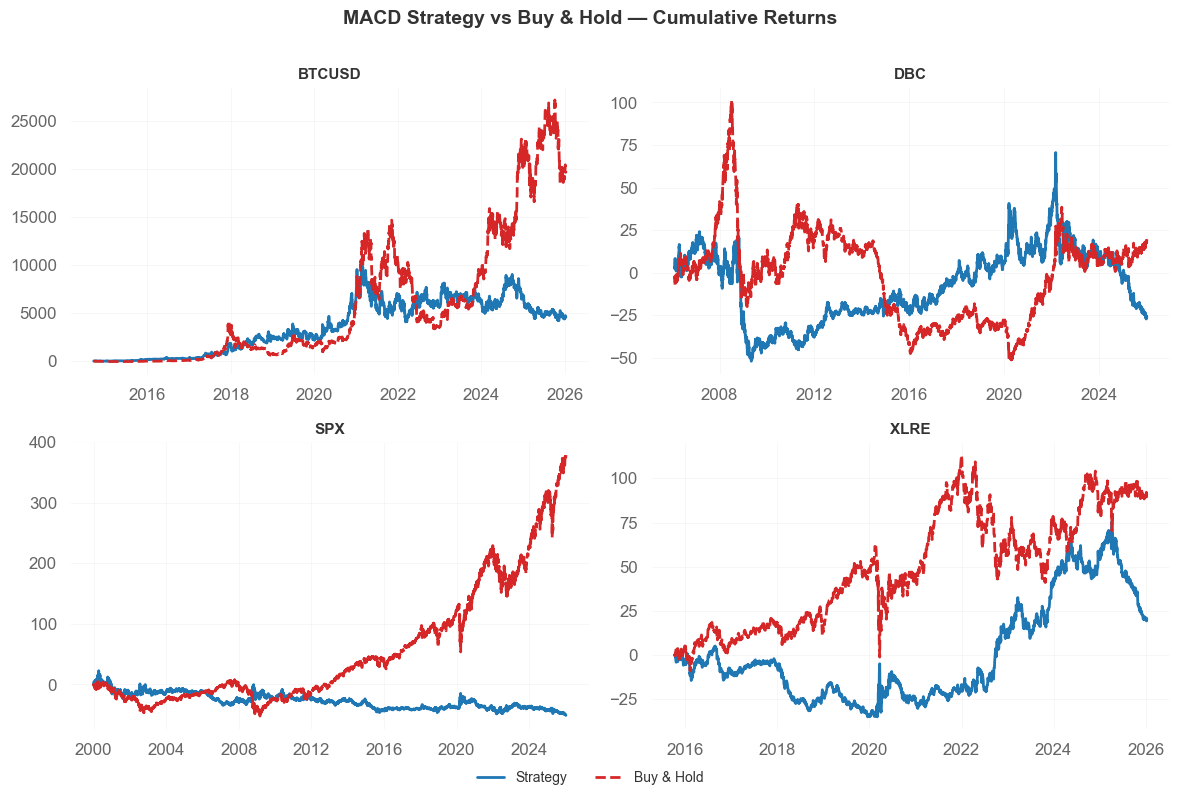

In [76]:

# ======================================
# CONFIG
# ======================================
tickers_to_plot = tickers[:4]  # garante 4 ativos
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)
axes = axes.flatten()

# ======================================
# LOOP DE PLOT
# ======================================
for ax, ticker in zip(axes, tickers_to_plot):
    df = data_dict[ticker].copy()

    # Retornos acumulados (%)
    strat_cum = df["strategy"].add(1).cumprod().sub(1) * 100
    bh_cum    = df["ret"].add(1).cumprod().sub(1) * 100

    ax.plot(df.index, strat_cum, linewidth=2, label="Strategy",color='tab:blue')
    ax.plot(df.index, bh_cum, linewidth=2, linestyle="--", label="Buy & Hold",color='tab:red')

    ax.set_title(ticker, fontsize=11, fontweight="bold")
    ax.grid(True, alpha=0.3)


# ======================================
# AJUSTES GERAIS
# ======================================
fig.suptitle(
    "MACD Strategy vs Buy & Hold — Cumulative Returns",
    fontsize=14,
    fontweight="bold"
)

# Legenda única
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=2,
    frameon=False,
    fontsize=10
)

plt.tight_layout(rect=[0, 0.02, 1, 0.98])
plt.show()


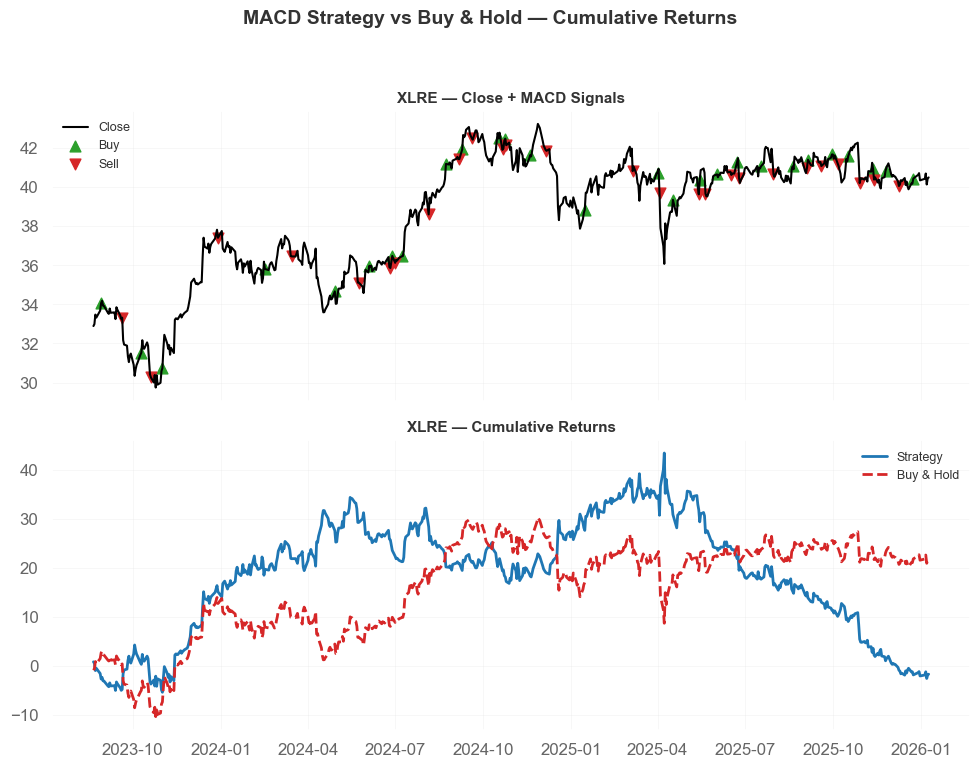

In [74]:
df = data_dict[ticker].copy().tail(600)

# Retornos acumulados (%)
strat_cum = df["strategy"].add(1).cumprod().sub(1) * 100
bh_cum    = df["ret"].add(1).cumprod().sub(1) * 100

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Coluna 1: Close + sinais MACD
ax0.plot(df.index, df["close"], color="black", linewidth=1.5, label="Close")
ax0.scatter(df.index[df["buy_signal"]], df.loc[df["buy_signal"], "close"],
            marker="^", color="tab:green", s=60, label="Buy")
ax0.scatter(df.index[df["sell_signal"]], df.loc[df["sell_signal"], "close"],
            marker="v", color="tab:red", s=60, label="Sell")
ax0.set_title(f"{ticker} — Close + MACD Signals", fontsize=11, fontweight="bold")
ax0.grid(True, alpha=0.3)
ax0.legend(frameon=False, fontsize=9)

# Coluna 2: Retornos acumulados
ax1.plot(df.index, strat_cum, linewidth=2, label="Strategy", color="tab:blue")
ax1.plot(df.index, bh_cum, linewidth=2, linestyle="--", label="Buy & Hold", color="tab:red")
ax1.set_title(f"{ticker} — Cumulative Returns", fontsize=11, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.legend(frameon=False, fontsize=9)

fig.suptitle("MACD Strategy vs Buy & Hold — Cumulative Returns", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0.02, 1, 0.95])
plt.show()
